# Backpropagation Part 2

In [1]:
import numpy as np
from tensorflow.keras.layers import Softmax, Dense, Input
from tensorflow.keras.losses import CategoricalCrossentropy

2023-05-26 18:06:28.845225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 18:06:28.985395: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-26 18:06:29.553851: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-26 18:06:29.553911: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

## Softmax

I've been wondering why exponentials are used in softmax. It has a deep connection with the concept of entropy in statistical mechanics. This brings back some memory of using Boltzman distribution to derive ideal gas law.

Boltzmann distribution describes the probability of a gas particle in a certain state as a function of temperature of the system and the state's energy where $k$ is the Boltzmann's constant.

$$
P(i) = \frac{\exp(\frac{-\epsilon_i}{kT})}{\sum_j \exp(\frac{-\epsilon_j}{kT})}
$$

This equation looks identical to softmax if we replace the energy, temperature, and Boltzmann constant term with our activation score $y$.

$$
P(i) = \frac{\exp(y_i)}{\sum_j \exp(y_j)}
$$

or

$$
log\left(P(i)\right) = y_i - log\left(\sum_j \exp(y_j)\right)
$$

However, it will overflow and underflow for extreme values.

In [2]:
def my_softmax(y):
    z = np.sum(np.exp(y), axis=1, keepdims=True)
    log_probs = y - np.log(z)
    return np.exp(log_probs)

# Suppose I have 2 samples and 3 scores for 3 classes.
y = np.array(
    [[-200, 100, 5], [-200, 100, -5]]
).astype(np.float64) * 1000

my_softmax(y)

/tmp/ipykernel_1392509/3941874065.py:2: RuntimeWarning: overflow encountered in exp
  z = np.sum(np.exp(y), axis=1, keepdims=True)


array([[0., 0., 0.],
       [0., 0., 0.]])

The numerical stable softmax will be implemented the following way.

$$
P(i) = \frac{\exp\left(y_i - max(\vec{y})\right)}{\sum_j \exp\left(y_j -max(\vec{y})\right)}
$$

In [3]:
softmax = Softmax()
softmax(y).numpy()

2023-05-26 18:06:30.449538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-26 18:06:30.455167: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-05-26 18:06:30.455196: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-26 18:06:30.455739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

array([[0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [9]:
def numerical_stable_softmax(logits):
    shifted_logits = logits - np.max(logits, axis=1, keepdims=True)
    z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(z)
    return np.exp(log_probs)

numerical_stable_softmax(y)

array([[0., 1., 0.],
       [0., 1., 0.]])

## Cross Entropy

After we performed softmax on the model output logits, we have probabilities for `N` samples and `K` classes. The cross entropy loss describes the dissimilarity between the predicted probability distribution and the true distribution for classes.

$$
\frac{1}{N} \sum_{n=1}^N p_n log(\hat{p}_n) + (1 - p_n) log(1 - \hat{p}_n)
$$

In [5]:
y_true = np.array([
    [0.3, 0.4, 0.3], [0.5, 0.5, 0.0], [1.0, 0.0, 0.0]
])
y_logits = np.array([
    [0.3, 0.4, 0.29], [0.5, 0.5, 0.01], [0.99, 0.01, 0.01]
])
CategoricalCrossentropy(from_logits=True)(y_true, y_logits).numpy()

0.8710621639531889

I will add `Softmax` logic into the cross entropy loss function.

In [6]:
from IPython.display import Code
Code(filename='losses/ce.py', language='python')

import numpy as np

class CrossEntropy:
    def __init__(self):
        self.y_true = None
        self.y_pred = None

    def __call__(self, y_true, y_logits):
        shifted_logits = y_logits - np.max(y_logits, axis=1, keepdims=True)
        denominator = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
        log_probs = shifted_logits - np.log(denominator)
        self.y_pred = np.exp(log_probs)
        self.y_true = y_true
        # Assume that y_true and y_logits have the same shape,
        # y_true has probabilities for multiple classes, i.e. one-hot encoding.
        # [
        #   [p1, p2, p3, ..., pC] => [0, 0, 1, ..., 0]
        #   [p1, p2, p3, ..., pC] => [0, 1, 0, ..., 0]
        # ]
        return -np.sum(y_true * log_probs) / y_true.shape[0]
    
    def gradients(self):
        if self.y_pred is None:
            raise ValueError("loss function must be forward propagated first")
        grad_y = (self.y_pred - self.y_true) / self.y_true.shape[0]
        return grad_y

In [7]:
from losses.ce import CrossEntropy
CrossEntropy()(y_true, y_logits)

0.8710621639531889

## Classify MNIST Digits with Numpy

I will again try to overfit the training data to show that gradients are computed correctly.

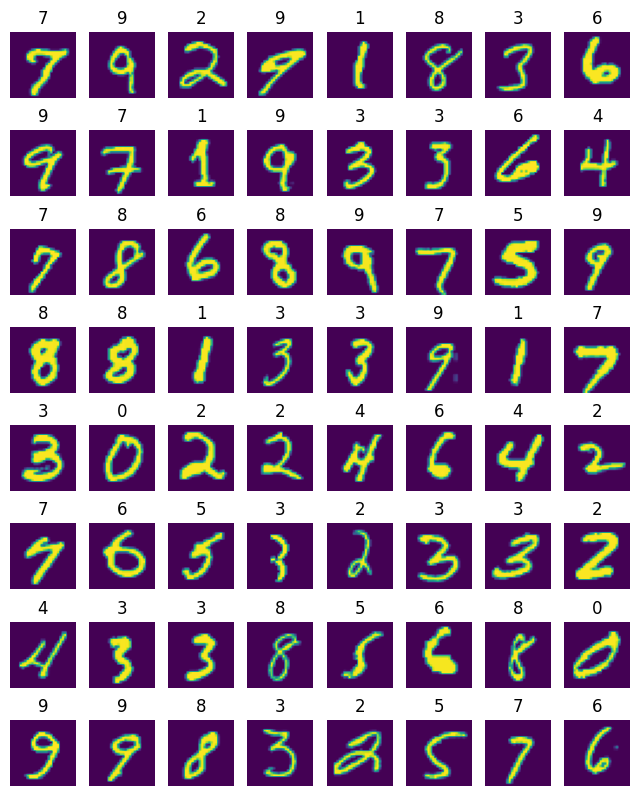

In [67]:
import numpy as np
from matplotlib import pyplot as plt
from layers.dense import Dense
from layers.relu import ReLU
from losses.ce import CrossEntropy
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data(path='mnist.npz')
_, axs = plt.subplots(8, 8, figsize=(8, 10))
for i in range(8):
    for j in range(8):
        k = np.random.randint(x_train.shape[0])
        axs[i][j].imshow(x_train[k])
        axs[i][j].axis('off')
        axs[i][j].set_title(y_train[k])

In [126]:
class NumpyModel:
    """Keep the model simple. Same as that of TensorFlow example.
    """
    def __init__(self, weight_stddev=0.01):
        self.params = {
            "dense_1/kernel": weight_stddev * np.random.randn(784, 128),
            "dense_1/bias": np.zeros((128,)),
            "dense_2/kernel": weight_stddev * np.random.randn(128, 10),
            "dense_2/bias": np.zeros((10,)),
        }
        self.dense_1 = Dense()
        self.act_1 = ReLU()
        self.dense_2 = Dense()

    def __call__(self, x):
        x = self.dense_1(x, self.params['dense_1/kernel'], self.params['dense_1/bias'])
        x = self.act_1(x)
        x = self.dense_2(x, self.params['dense_2/kernel'], self.params['dense_2/bias'])
        return x

### Verify Dimensions

Run a quick demo to make sure all dimensions match up.

In [127]:
np_model = NumpyModel()
loss_fn = CrossEntropy()
batch_size = 4
batch_logits = np_model(x_train[:batch_size].reshape((batch_size, -1)))
print("Predicted Logits\n", batch_logits.round(2))

batch_probs = numerical_stable_softmax(batch_logits)
batch_y_pred = np.argmax(batch_probs, axis=-1)
print("Predicted Labels", batch_y_pred)
print("True Labels", y_train[:batch_size])

# Compute loss using the one-hot encoded version of target labels.
batch_y_true = np.eye(10)[y_train[:batch_size]]
loss_fn(batch_y_true, batch_logits)

Predicted Logits
 [[-1.1   4.82 -0.09  1.19 -1.71  1.51 -0.8   4.02 -0.22 -1.47]
 [-1.75  3.12  0.33  4.    1.29 -1.61  2.79  1.2  -0.94 -2.59]
 [-0.76 -0.05  0.89  1.92  2.21 -0.61  0.19  1.78 -0.33 -1.65]
 [ 0.65  1.23 -1.45  3.24  0.33 -0.73 -1.   -0.07  1.05 -1.96]]
Predicted Labels [1 3 4 3]
True Labels [5 0 4 1]


3.4113826708535013

### Training Loop

In [132]:
from optimizers.adam import Adam
from tqdm import tqdm

np.random.seed(1337)
N = x_train.shape[0]
batch_size = 128
epochs = 10
history = []

optim = Adam(learning_rate=1e-3)
np_model = NumpyModel()
loss_fn = CrossEntropy()
step = 1
progress = tqdm(total=epochs * N // batch_size)
for epoch in range(epochs):
    for i in range(N // batch_size):
        start = i * batch_size
        end = start + batch_size
        batch_x = x_train[start:end]
        batch_y = y_train[start:end]
        
        batch_y_logits = np_model(batch_x.reshape((batch_size, -1)))
        batch_y_true = np.eye(10)[batch_y]
        
        loss = loss_fn(batch_y_true, batch_y_logits)
        grad_affine_2 = loss_fn.gradients()
        grad_affine_1_act, grad_dense_2_kernel, grad_dense_2_bias = np_model.dense_2.gradients(grad_affine_2)
        grad_affine_1 = np_model.act_1.gradients(grad_affine_1_act)
        _, grad_dense_1_kernel, grad_dense_1_bias = np_model.dense_1.gradients(grad_affine_1)
        
        grads = {
            "dense_1/kernel": grad_dense_1_kernel,
            "dense_1/bias": grad_dense_1_bias,
            "dense_2/kernel": grad_dense_2_kernel,
            "dense_2/bias": grad_dense_2_bias,
        }
        for key in grads:
            optim.update(step, key, np_model.params, grads)
        step += 1
        progress.update()
    
    y_logits = np_model(x_train.reshape((N, -1)))
    y_true = np.eye(10)[y_train]
    loss = loss_fn(y_true, y_logits)
    history.append((epoch, loss))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 4680/4687 [00:41<00:00, 100.94it/s]

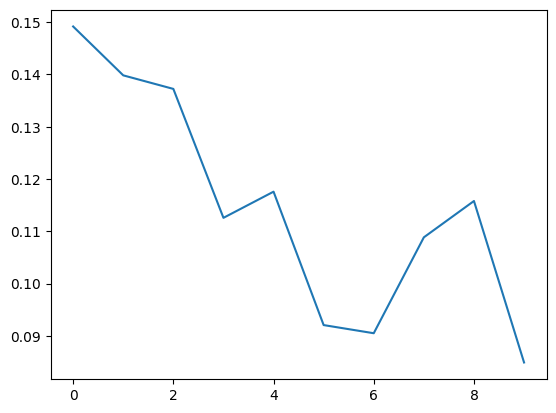

In [133]:
plt.plot([dp[0] for dp in history], [dp[1] for dp in history])

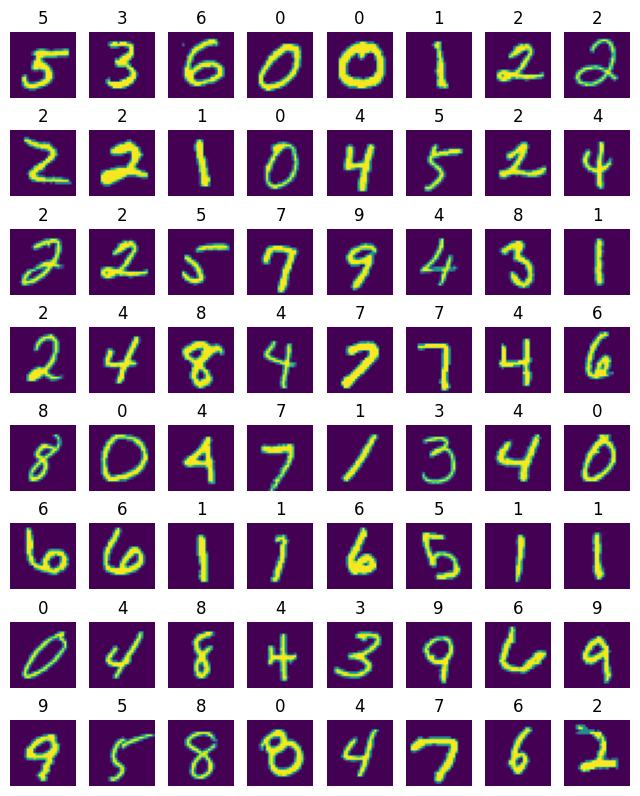

In [137]:
logits = np_model(x_test.reshape((x_test.shape[0], -1)))
probs = numerical_stable_softmax(logits)
y_pred = np.argmax(probs, axis=-1)

_, axs = plt.subplots(8, 8, figsize=(8, 10))
for i in range(8):
    for j in range(8):
        k = np.random.randint(x_test.shape[0])
        axs[i][j].imshow(x_test[k])
        axs[i][j].axis('off')
        axs[i][j].set_title(y_pred[k])

In [142]:
f"Accuracy: {np.sum(y_test == y_pred) / y_test.shape[0]}"

'Accuracy: 0.9629'